# Neuromorphic computing 

The original paper

P. U. Diehl and M. Cook. **Unsupervised learning of digit recognition using spike-timing-dependent plasticity**. Frontiers in computational neuroscience, 9:99, 2015.
https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full

In [1]:
import numpy as np
import matplotlib as plt
from brian2 import *
import brian2 as b
import random
import mnist
import scipy.misc
import time

%matplotlib inline

# Load MNIST data

In [2]:
train_imgs = mnist.train_images()[0:6000, :, :]
train_labels = mnist.train_labels()[0:6000]
test_imgs = mnist.test_images()[0:1000, :, :]
test_labels = mnist.test_labels()[0:1000]

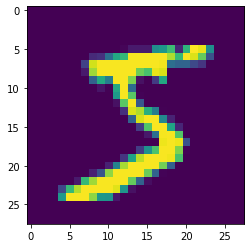

In [3]:
plt.imshow(train_imgs[0, :, :])
plt.show()

# Initialize Function

In [4]:
def get_matrix_from_file(fileName):
    offset = len(ending) + 4
    if fileName[-4-offset] == 'X':
        n_src = n_input                
    else:
        if fileName[-3-offset]=='e':
            n_src = n_e
        else:
            n_src = n_i
    if fileName[-1-offset]=='e':
        n_tgt = n_e
    else:
        n_tgt = n_i
    readout = np.load(fileName)
    print (readout.shape, fileName)
    value_arr = np.zeros((n_src, n_tgt))
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [5]:
def get_recognized_number_ranking(assignments, spike_rates):
    summed_rates = [0] * 10
    num_assignments = [0] * 10
    for i in range(10):
        num_assignments[i] = len(np.where(assignments == i)[0])
        if num_assignments[i] > 0:
            summed_rates[i] = np.sum(spike_rates[assignments == i]) / num_assignments[i]
    return np.argsort(summed_rates)[::-1]

# assign the labels to each neuron
def get_new_assignments(result_monitor, label):
    rate = np.zeros(n_e)
    assignments = np.zeros(n_e)
    input_nums = np.asarray(label)
    maximum_rate = [0] * n_e    
    for j in range(10):
        num_assignments = len(np.where(input_nums == j)[0])
        if num_assignments > 0:
            rate = np.sum(result_monitor[input_nums == j], axis = 0) / num_assignments
        for i in range(n_e):
            if rate[i] > maximum_rate[i]:
                maximum_rate[i] = rate[i]
                assignments[i] = j
    return assignments

def plot_performance(fig_num):
    num_evaluations = int(num_examples/update_interval)
    time_steps = range(0, num_evaluations)
    performance = np.zeros(num_evaluations)
    fig = b.figure(fig_num, figsize = (5, 5))
    fig_num += 1
    ax = fig.add_subplot(111)
    im2, = ax.plot(time_steps, performance) #my_cmap
    b.ylim(ymax = 100)
    b.title('Classification performance')
    fig.canvas.draw()
    return im2, performance, fig_num, fig

def get_current_performance(performance, current_example_num):
    current_evaluation = int(current_example_num/update_interval)
    start_num = current_example_num - update_interval
    end_num = current_example_num
    difference = outputNumbers[start_num:end_num, 0] - label[start_num:end_num]
    correct = len(np.where(difference == 0)[0])
    performance[current_evaluation] = correct / float(update_interval) * 100
    return performance

def update_performance_plot(im, performance, current_example_num, fig):
    performance = get_current_performance(performance, current_example_num)
    im.set_ydata(performance)
    fig.canvas.draw()
    return im, performance, fig

def normalize_weight():
    weight_norm = 78
    temp_w = np.copy(S_XeAe.w)
    temp_w = temp_w.reshape((n_input, n_e))
    colsum = np.sum(temp_w, axis=0)
    colfac = weight_norm / colsum
    for i in range(n_e):
        temp_w[:, i] *= colfac[i] 

# Config the parameters and equations

In [6]:
codegen.target = 'auto'

training_mode = True
if training_mode == True:
    data = train_imgs
    label = train_labels
    num_examples = 6000
else:
    data = test_imgs
    label = test_labels
    num_examples = 1000


## Original Architecture 

In [7]:
start_scope()

n_input = 28*28      
n_e = 400
n_i = n_e

Ee = 0 * mV
El = -74 * mV
tau_e = 100 * ms
tau_i = 10 * ms

v_rest_e = -65. * mV 
v_rest_i = -60. * mV 
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms

ending = ''

taupre = taupost = 20 * ms
gmax = .01
dApre = .01
dApost1 = -dApre * taupre / taupost * 1.05
dApost2 = -dApre * taupre / taupost * 1.05
dApost1 *= gmax
dApost2 *= gmax
dApre *= gmax

tc_pre_ee = 20*b.ms
tc_post_1_ee = 20*b.ms
tc_post_2_ee = 40*b.ms
nu_ee_pre =  0.0001      # learning rate
nu_ee_post = 0.01       # learning rate
wmax_ee = 1.0
exp_ee_pre = 0.2
exp_ee_post = exp_ee_pre
STDP_offset = 0.4

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + (I_synE+I_synI) / nS) / (100*ms)  : volt  (unless refractory)
        I_synE = ge * nS *         -v                           : amp
        I_synI = gi * nS * (-100.*mV-v)                          : amp
        dge/dt = -ge/(1.0*ms)                                   : 1
        dgi/dt = -gi/(2.0*ms)                                  : 1
        '''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) + (I_synE+I_synI) / nS) / (10*ms)  : volt  (unless refractory)
        I_synE = ge * nS *         -v                           : amp
        I_synI = gi * nS * (-85.*mV-v)                          : amp
        dge/dt = -ge/(1.0*ms)                                   : 1
        dgi/dt = -gi/(2.0*ms)                                  : 1
        '''
stdp_ee = '''
        w : 1
        post2before                            : 1
        dApre/dt   =   -Apre/(tc_pre_ee)         : 1  (event-driven)
        dApost1/dt  = -Apost1/(tc_post_1_ee)     : 1  (event-driven)
        dApost2/dt  = -Apost2/(tc_post_2_ee)     : 1  (event-driven)
        '''
stdp_ee_pre_e = '''
        ge += w
        Apre += dApre
        w = clip(w + (nu_ee_pre * Apost1), 0, gmax)
        '''
stdp_ee_pre_i = '''
        gi += w
        Apre += dApre 
        w = clip(w + (nu_ee_pre * Apost1), 0, gmax)
        '''
stdp_ee_post = '''
        post2before += Apost2 
        Apost1 += dApost1
        Apost2 += dApost2
        w = clip(w + (nu_ee_post * Apre * post2before), 0, gmax) 
        '''

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 4s
38.636561155319214


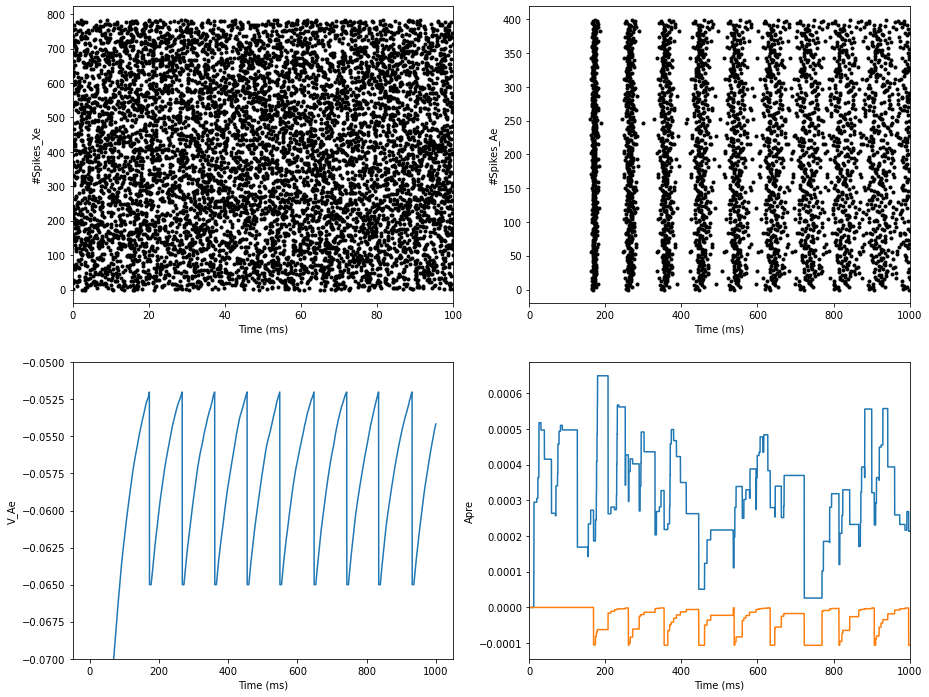

In [8]:
tic = time.time()

# initial input neuron and determine 'rates' as a variable
Xe = NeuronGroup(n_input, 'rates : Hz', threshold='rand()<rates*dt')
Xe.rates = 100*Hz

# initial next layer
Ae = NeuronGroup(n_e, model=neuron_eqs_e, threshold='v > v_thresh_e', reset='v = v_reset_e', refractory=refrac_e, method='euler')
Ai = NeuronGroup(n_i, model=neuron_eqs_i, threshold='v > v_thresh_i', reset='v = v_reset_i', refractory=refrac_i, method='euler')

# initialize membrain voltage of each neuron
Ae.v = v_reset_e - 40*mV
Ai.v = v_reset_i - 40*mV

if training_mode == True:
    # input to excitatory with all-to-all connection
    S_XeAe = Synapses(Xe, Ae, stdp_ee, on_pre = stdp_ee_pre_e, on_post = stdp_ee_post)
    S_XeAe.connect()
    S_XeAe.w = 'rand()*gmax'
    S_XeAe.delay = 'rand() * 10 * ms'
    # excitatory to inhibitory with one-to-one connection
    S_AeAi = Synapses(Ae, Ai, stdp_ee, on_pre = stdp_ee_pre_e, on_post = stdp_ee_post)
    S_AeAi.connect(condition='i==j')
    S_AeAi.w = 'rand()*gmax'
    # inhibitory to excitatory with all-to-all except the post-neuron that has the same index
    S_AiAe = Synapses(Ai, Ae, stdp_ee, on_pre = stdp_ee_pre_i, on_post = stdp_ee_post)
    S_AiAe.connect(condition='i!=j')
    S_AiAe.w = 'rand()*gmax'
else:
    # load trained weight
    weight_XeAe = get_matrix_from_file('XeAe.npy')
    weight_AeAi = get_matrix_from_file('AeAi.npy')
    weight_AiAe = get_matrix_from_file('AiAe.npy')
    # input to excitatory with all-to-all connection
    S_XeAe = Synapses(Xe, Ae, 'w : 1')
    S_XeAe.connect()
    S_XeAe.w = weight_XeAe.flatten()
    # excitatory to inhibitory with one-to-one connection
    S_AeAi = Synapses(Ae, Ai, 'w : 1')
    S_AeAi.connect(j='i')
    S_AeAi.w = weight_AeAi.flatten()
    # inhibitory to excitatory with all-to-all except the post-neuron that has the same index
    S_AiAe = Synapses(Ai, Ae, 'w : 1')
    S_AiAe.connect(condition='i!=j')
    S_AiAe.w = weight_AiAe.flatten()

# monitor  
spike_Xe = SpikeMonitor(Xe)
spike_Ae = SpikeMonitor(Ae)
state_Ae = StateMonitor(Ae, 'v', record=[200])
state_XeAe = StateMonitor(S_XeAe, ['w', 'Apre', 'Apost1'], record=[0, 1, 2])

run(1*second, report='text')

figure(figsize=(15, 12))
# spike monitor
subplot(221)
plot(spike_Xe.t/ms, spike_Xe.i, '.k')
xlabel('Time (ms)')
ylabel('#Spikes_Xe')
xlim(0, 100)
subplot(222)
plot(spike_Ae.t/ms, spike_Ae.i, '.k')
xlabel('Time (ms)')
ylabel('#Spikes_Ae')
xlim(0, 1000)
# state monitor
subplot(223)
plot(state_Ae.t/ms, state_Ae.v[0])
xlabel('Time (ms)')
ylabel('V_Ae')
ylim(-0.07, -0.05)
subplot(224)
plot(state_XeAe.t/ms, state_XeAe.Apre[0], label='Apre')
plot(state_XeAe.t/ms, state_XeAe.Apost1[0], label='Apost')
xlabel('Time (ms)')
ylabel('Apre')
xlim(0, 1000)
toc = time.time()

print (toc-tic)

## Own Architecture

In [47]:
# start_scope()

# n_input = 28*28      
# n_e = 400
# n_i = n_e

# Ee = 0 * mV
# El = -74 * mV
# tau_e = 100 * ms
# tau_i = 10 * ms

# v_rest_e = -65. * mV 
# v_rest_i = -60. * mV 
# v_reset_e = -65. * mV
# v_reset_i = -45. * mV
# v_thresh_e = -54. * mV
# v_thresh_i = -40. * mV
# refrac_e = 5. * ms
# refrac_i = 2. * ms

# ending = ''

# taupre = taupost = 20 * ms
# gmax = .01
# apre = .01
# apost = -apre * taupre / taupost * 1.05
# apost *= gmax
# apre *= gmax

# neuron_eqs_e = '''
#         dv/dt = (ge * (Ee-v) + El - v) / tau_e : volt (unless refractory)
#         dge/dt = -ge / (1.0*ms) : 1
# '''

# neuron_eqs_i = '''
#         dv/dt = (ge * (Ee-v) + El - v) / tau_i : volt (unless refractory)
#         dge/dt = -ge / (1.0*ms) : 1
# '''

# stdp_ee = '''
#         w : 1
#         dApre/dt = -Apre / taupre : 1 (event-driven)
#         dApost/dt = -Apost / taupost : 1 (event-driven)
# '''
# stdp_ee_pre = '''
#         ge += w
#         Apre += apre
#         w = clip(w + Apost, 0, gmax)
# '''
# stdp_ee_post = '''
#         Apost += apost
#         w = clip(w + Apre, 0, gmax)
# '''

In [48]:
# # initial input neuron and determine 'rates' as a variable
# Xe = NeuronGroup(n_input, 'rates : Hz', threshold='rand()<rates*dt')
# Xe.rates = 100*Hz

# # initial next layer
# Ae = NeuronGroup(n_e, model=neuron_eqs_e, threshold='v > v_thresh_e', reset='v = v_reset_e', refractory=refrac_e, method='euler')
# Ai = NeuronGroup(n_i, model=neuron_eqs_i, threshold='v > v_thresh_i', reset='v = v_reset_i', refractory=refrac_i, method='euler')

# # initialize membrain voltage of each neuron
# Ae.v = v_reset_e - 40*mV
# Ai.v = v_reset_i - 40*mV

# if training_mode == True:
#     # input to excitatory with all-to-all connection
#     S_XeAe = Synapses(Xe, Ae, stdp_ee, on_pre = stdp_ee_pre, on_post = stdp_ee_post)
#     S_XeAe.connect()
#     S_XeAe.w = 'rand()*gmax'
#     init_w_XeAe = S_XeAe.w
#     S_XeAe.delay = 'rand() * 10 * ms'
#     # excitatory to inhibitory with one-to-one connection
#     S_AeAi = Synapses(Ae, Ai, stdp_ee, on_pre = stdp_ee_pre, on_post = stdp_ee_post)
#     S_AeAi.connect(j='i')
#     S_AeAi.w = 'rand()*gmax'
#     init_w_AeAi = S_AeAi.w
#     # inhibitory to excitatory with all-to-all except the post-neuron that has the same index
#     S_AiAe = Synapses(Ai, Ae, stdp_ee, on_pre = stdp_ee_pre, on_post = stdp_ee_post)
#     S_AiAe.connect(condition='i!=j')
#     S_AiAe.w = 'rand()*gmax'
#     init_w_AiAe = S_AiAe.w
# else:
#     # load trained weight
#     weight_XeAe = get_matrix_from_file('XeAe.npy')
#     weight_AeAi = get_matrix_from_file('AeAi.npy')
#     weight_AiAe = get_matrix_from_file('AiAe.npy')
#     # input to excitatory with all-to-all connection
#     S_XeAe = Synapses(Xe, Ae, 'w : 1')
#     S_XeAe.connect()
#     S_XeAe.w = weight_XeAe.flatten()
#     # excitatory to inhibitory with one-to-one connection
#     S_AeAi = Synapses(Ae, Ai, 'w : 1')
#     S_AeAi.connect(j='i')
#     S_AeAi.w = weight_AeAi.flatten()
#     # inhibitory to excitatory with all-to-all except the post-neuron that has the same index
#     S_AiAe = Synapses(Ai, Ae, 'w : 1')
#     S_AiAe.connect(condition='i!=j')
#     S_AiAe.w = weight_AiAe.flatten()

# # monitor  
# spike_Xe = SpikeMonitor(Xe)
# spike_Ae = SpikeMonitor(Ae)
# state_Ae = StateMonitor(Ae, 'v', record=[0, 1, 2])
# state_XeAe = StateMonitor(S_XeAe, ['w', 'Apre', 'Apost'], record=[0, 1, 2])
# # store()
# # run(5*second, report='text')

# # figure(figsize=(8, 10))
# # subplot(511)
# # plot(spike_Xe.t/ms, spike_Xe.i, '.k')
# # xlabel('Time (ms)')
# # ylabel('#Spikes')
# # xlim(0, 10)
# # subplot(512)
# # plot(spike_Ae.t/ms, spike_Ae.i, '.k')
# # xlabel('Time (ms)')
# # ylabel('#Spikes')
# # xlim(0, 1000)
# # subplot(513)
# # plot(state_Ae.t/ms, state_Ae.v[1])
# # xlabel('Time (ms)')
# # ylabel('V')
# # ylim(-0.07, -0.05)
# # subplot(514)
# # plot(state_XeAe.t/ms, state_XeAe.Apre[0], label='Apre')
# # plot(state_XeAe.t/ms, state_XeAe.Apost[0], label='Apost')
# # xlabel('Time (ms)')
# # ylabel('Apre')
# # subplot(515)
# # plot(state_XeAe.t/ms, state_XeAe.w[0] / gmax)
# # plot(state_XeAe.t/ms, state_XeAe.w[1] / gmax)
# # plot(state_XeAe.t/ms, state_XeAe.w[2] / gmax)
# # xlabel('Time (ms)')
# # ylabel('Weight')

# Main

In [ ]:
idx = 0
input_intensity = 2.
start_input_intensity = 2.
update_interval = 100
resting_time = 150 * ms
input_numbers = [0] * num_examples

previous_spike_count = np.zeros(n_e)
result_monitor = np.zeros((update_interval, n_e))
assignments = np.zeros(n_e)
outputNumbers = np.zeros((num_examples, 10))

do_plot_performance = True
fig_num = 1

if do_plot_performance:
    performance_monitor, performance, fig_num, fig_performance = plot_performance(fig_num)
    
while idx < len(data):
    normalize_weight()
    rates = data[idx, :, :].reshape((n_input)) / 8 * input_intensity
    Xe.rates = rates * Hz
    run(350*ms)
    
    # update the assignment
    if (idx % update_interval) == 0 and idx > 0:
        assignments = get_new_assignments(result_monitor[:], input_numbers[idx - update_interval: idx])
        print (assignments)
    
    current_spike_count = np.asarray(spike_Ae.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_Ae.count[:])
    
    if np.sum(current_spike_count) < 5:
        input_intensity += 2
        Xe.rates = 0 * Hz
        run(resting_time)
        print (input_intensity, end='\r')
    else:
        result_monitor[idx%update_interval, :] = current_spike_count
        
        if training_mode: 
            input_numbers[idx] = train_labels[idx]
            
        outputNumbers[idx,:] = get_recognized_number_ranking(assignments, result_monitor[idx%update_interval,:])
        input_intensity = start_input_intensity
        
        if (idx % 100 == 0) and (idx > 0):
            print ('runs done:', idx, 'of', int(num_examples))
        if (idx % update_interval == 0) and (idx > 0):
            unused, performance, fig = update_performance_plot(performance_monitor, performance, idx, fig_performance)
            fig.savefig('performance.png')
            print ('Classification performance', performance[int(idx/update_interval)])
            
        Xe.rates = 0 * Hz
        run(resting_time)
        idx += 1
        
# save weight for testing phase
np.save('XeAe.npy', S_XeAe.w)
np.save('AeAi.npy', S_AeAi.w)
np.save('AiAe.npy', S_AiAe.w)